In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

In [7]:
path = "data.csv"

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


data = pd.read_csv(path)
#data.sort_values(by=['id'])

display(data.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [8]:
#Finding missing values
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")

fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#Finding duplicate observations
duplicate = data[data.duplicated()]
duplicate

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32


In [9]:
#Remove unnecessary variables
data = data.drop(['id', 'Unnamed: 32'], axis = 1)

y = np.array(data.diagnosis.tolist())
data2 = data.copy()
data2.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

#Replace diagnosis values (M = 1, B = 0)
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
display(data.head())
display(data.describe())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


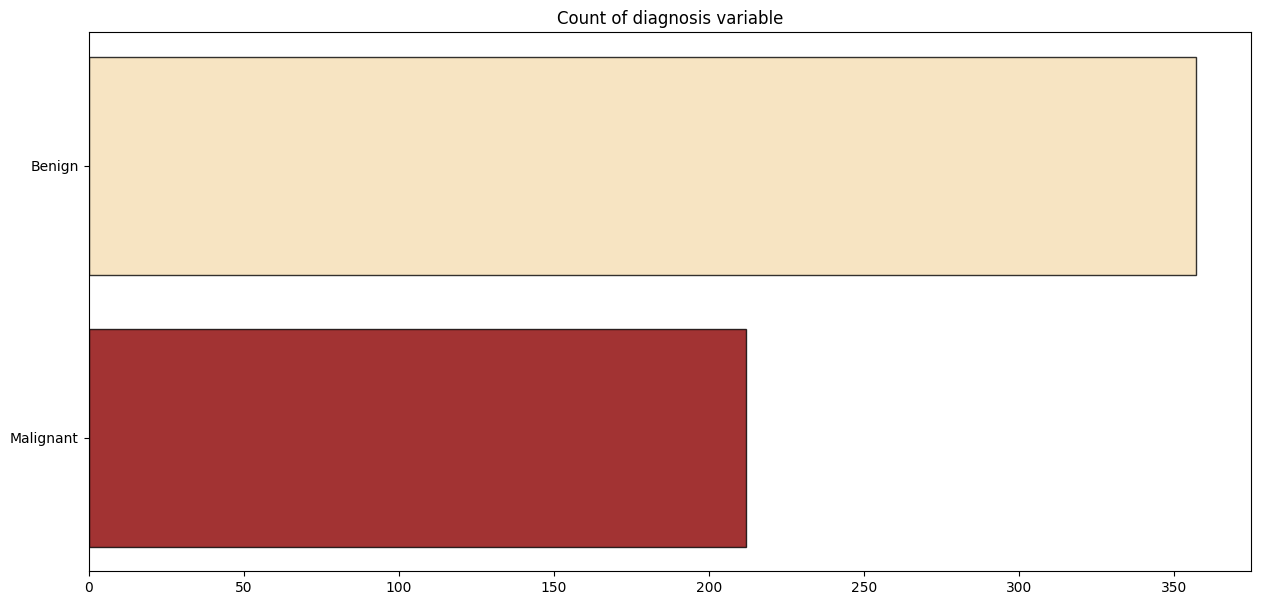

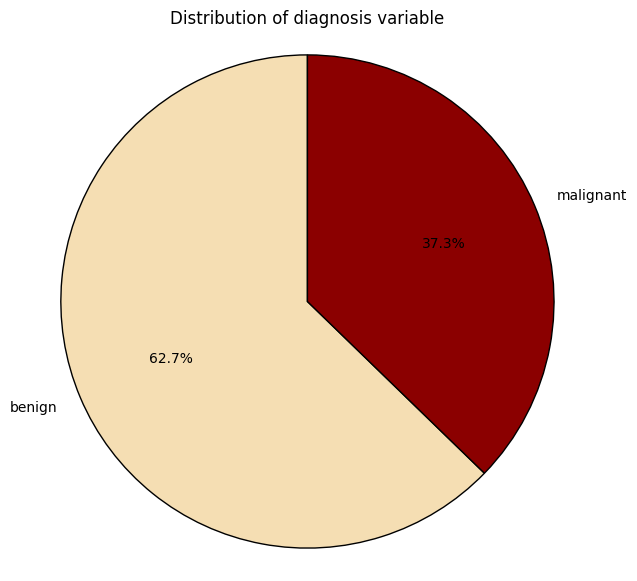

In [10]:
#EDA
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]
counts = [len(M), len(B)]

#Bar Plot
plt.figure(figsize=(15, 7))
plt.barh(['Malignant', 'Benign'], counts, color=['darkred', 'wheat'], edgecolor='#000000', alpha=0.8)
plt.title('Count of diagnosis variable')
plt.show()

#Pie Chart
diagnosis_counts = data['diagnosis'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(diagnosis_counts, labels=['benign', 'malignant'], colors=['wheat','darkred'], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=1, edgecolor='#000000'))
plt.axis('equal')
plt.title('Distribution of diagnosis variable')
plt.show()

In [11]:
#Distribution Plots
def distributionPlots(variable, bin):
  mal = M[variable]
  ben = B[variable]

  plt.figure(figsize=(10, 6))

  sns.kdeplot(mal, color='darkred', label='Malignant', fill=True, linewidth=2)
  sns.kdeplot(ben, color='wheat', label='Benign', fill=True, linewidth=2)

  plt.xlabel(variable)
  plt.ylabel('Density')
  plt.title('Density Plot for ' + variable)

  plt.legend()
  plt.show()

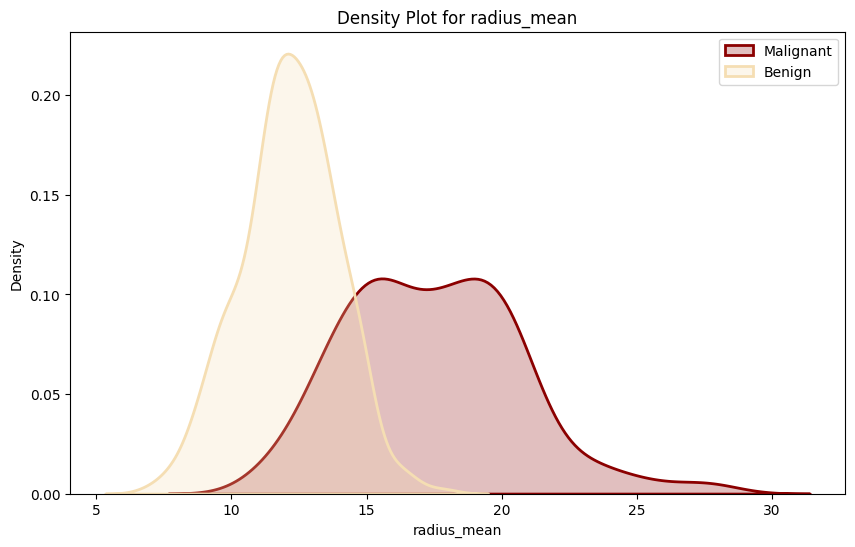

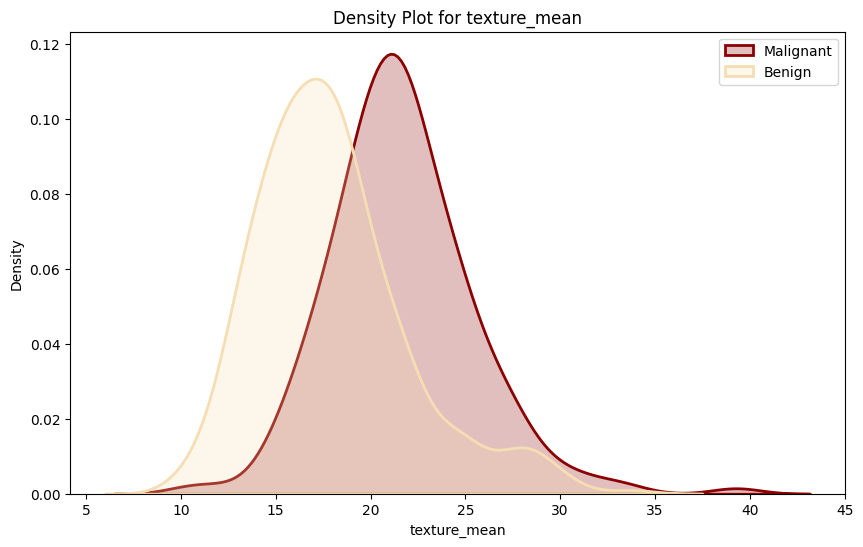

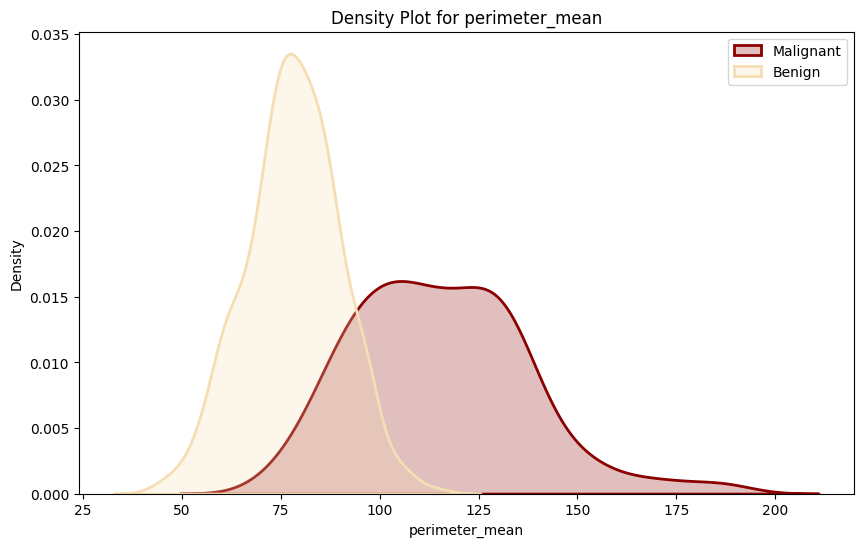

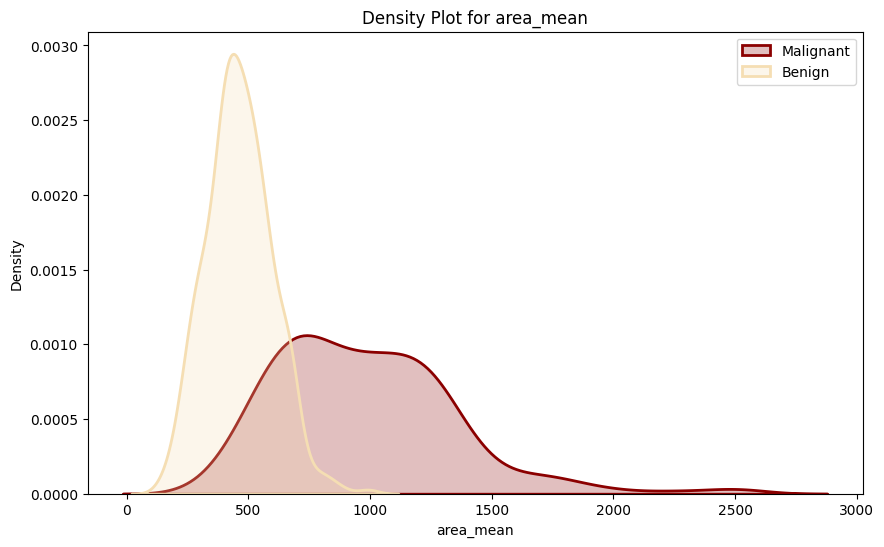

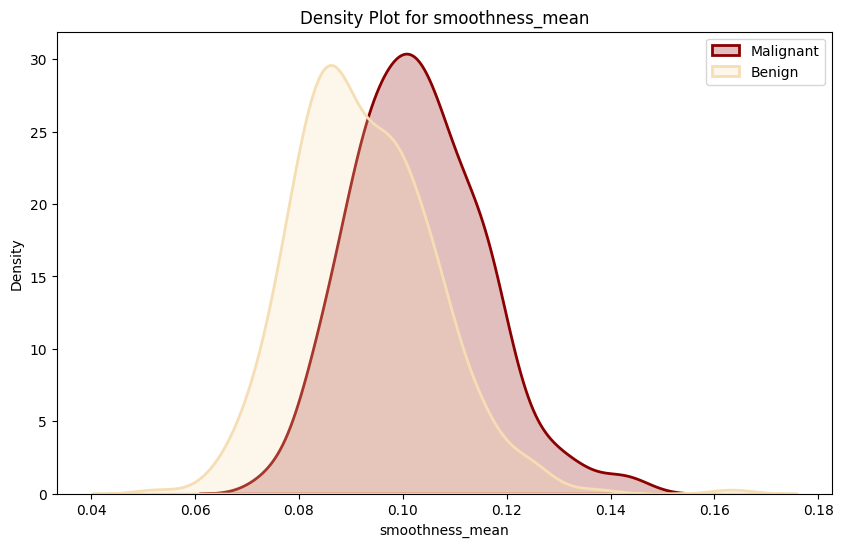

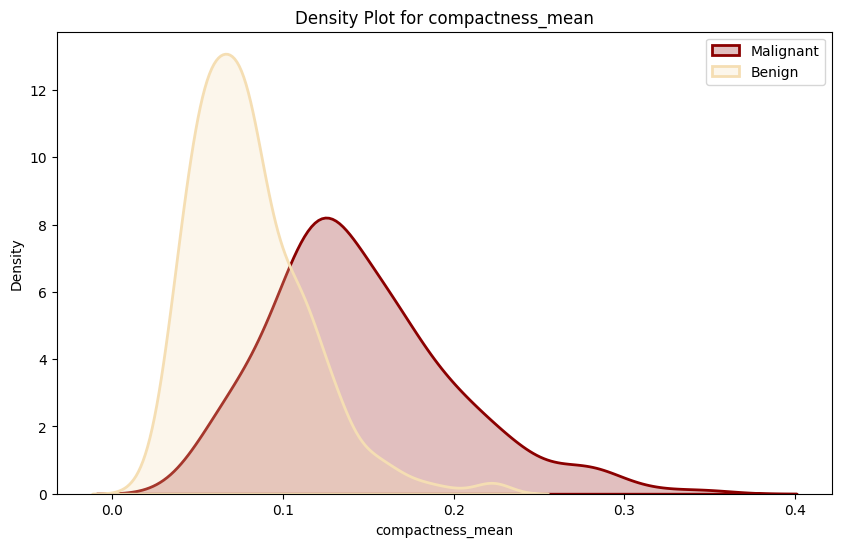

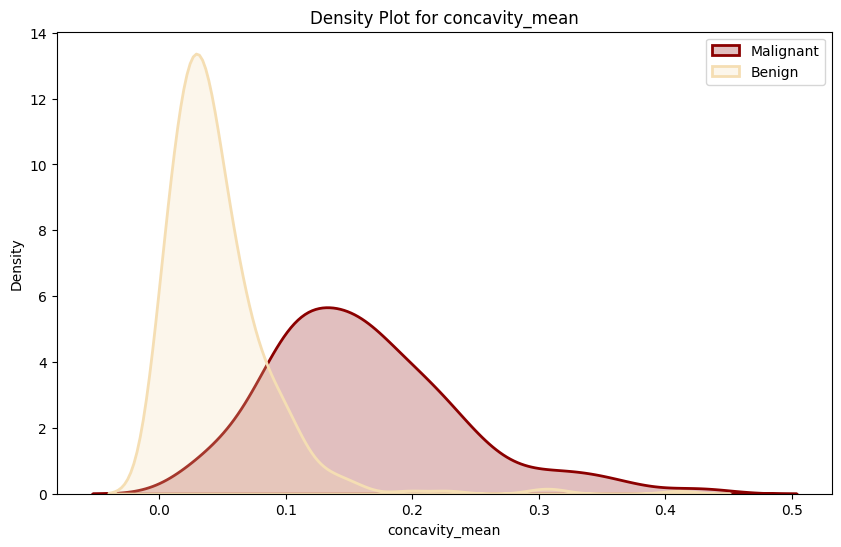

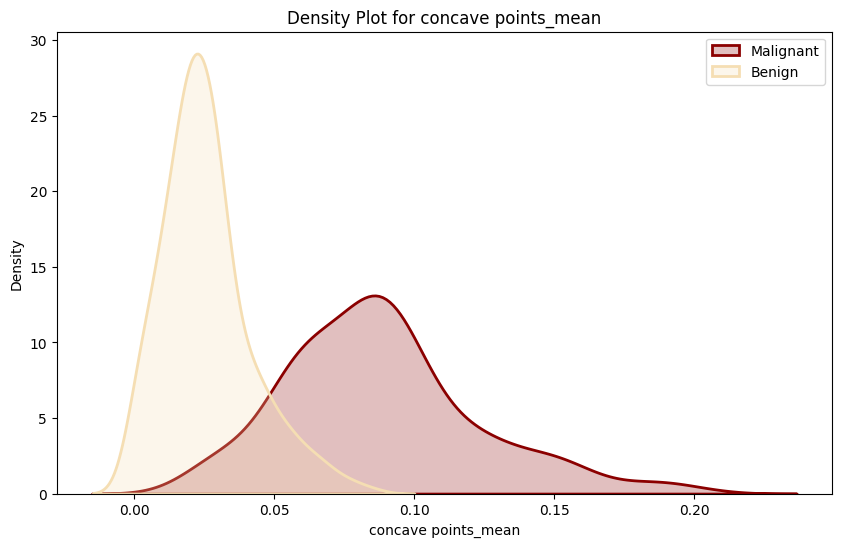

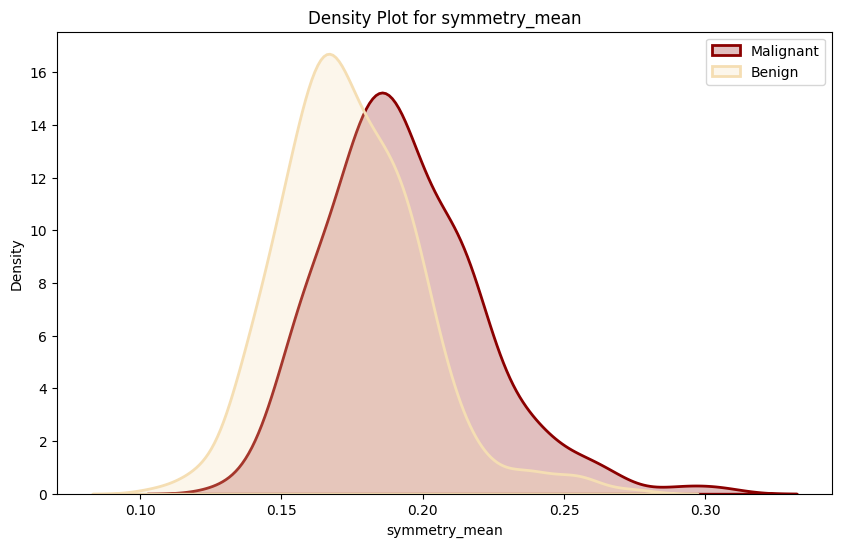

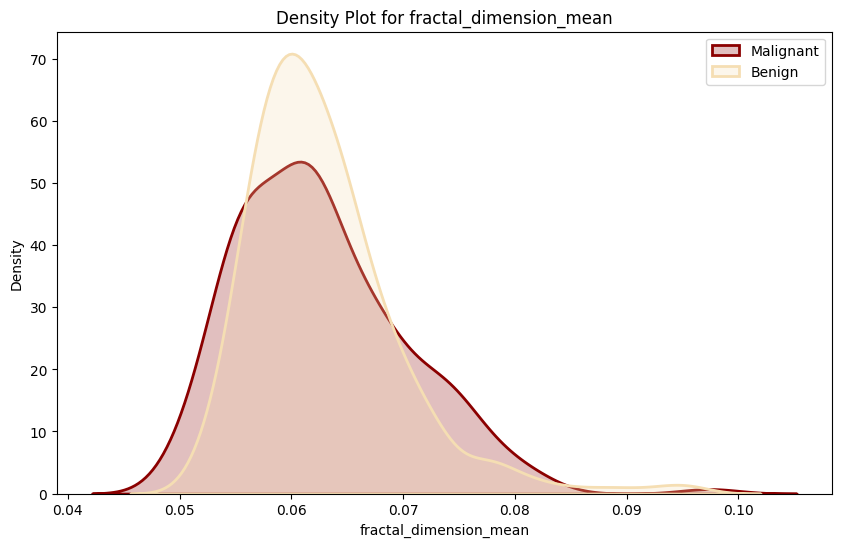

In [12]:
#Mean Features
distributionPlots('radius_mean', .5)
distributionPlots('texture_mean', .5)
distributionPlots('perimeter_mean', 5)
distributionPlots('area_mean', 10)
distributionPlots('smoothness_mean', .5)
distributionPlots('compactness_mean', .5)
distributionPlots('concavity_mean', .5)
distributionPlots('concave points_mean', .5)
distributionPlots('symmetry_mean', .5)
distributionPlots('fractal_dimension_mean', .5)

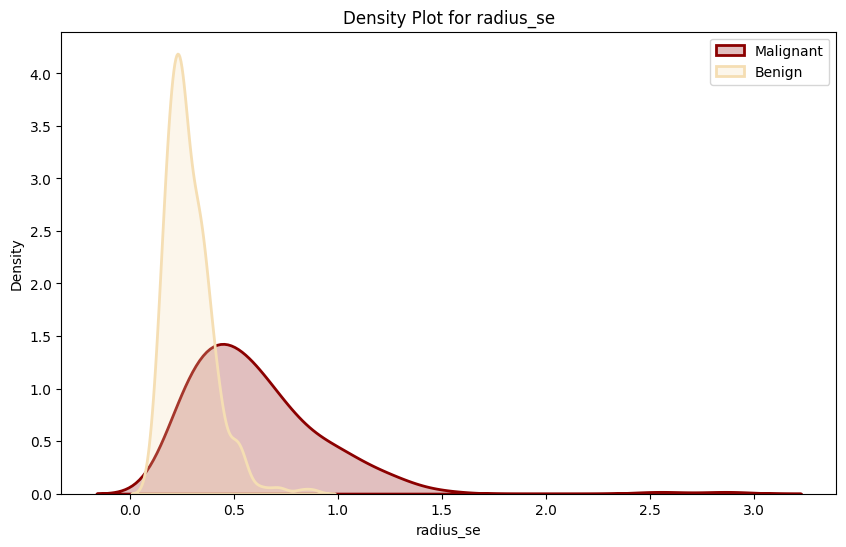

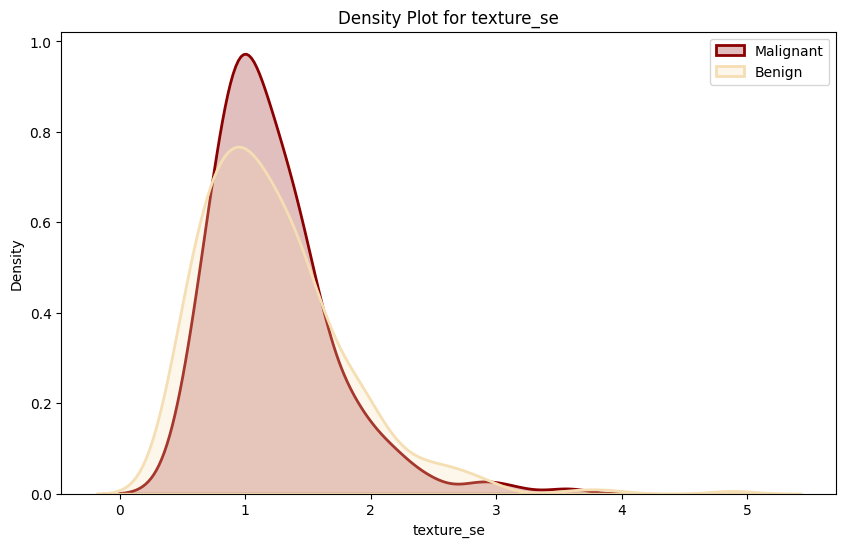

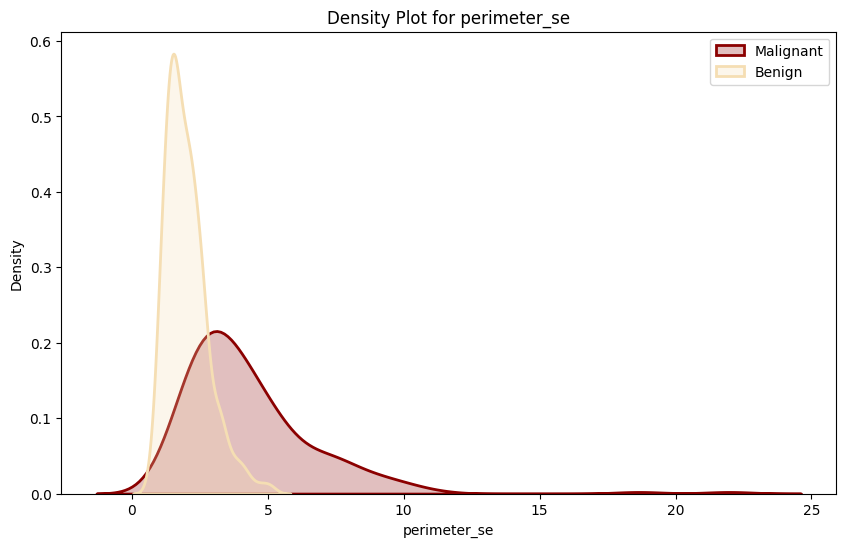

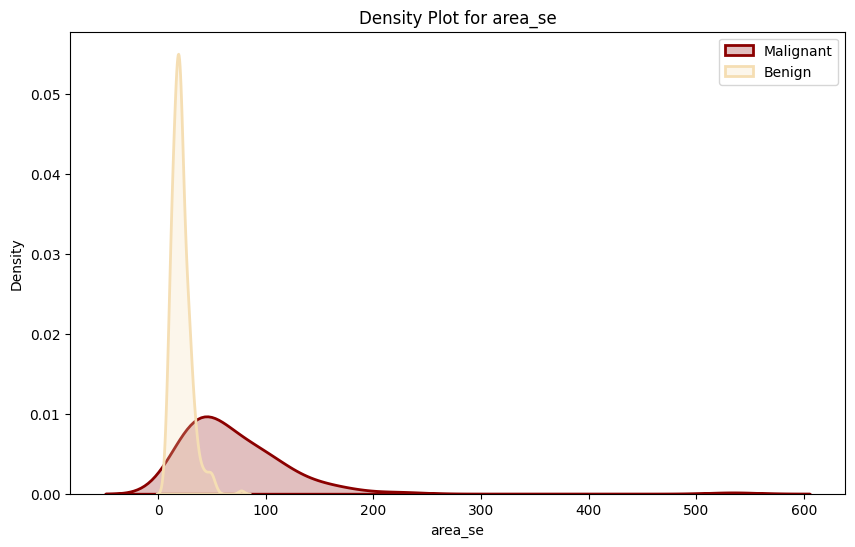

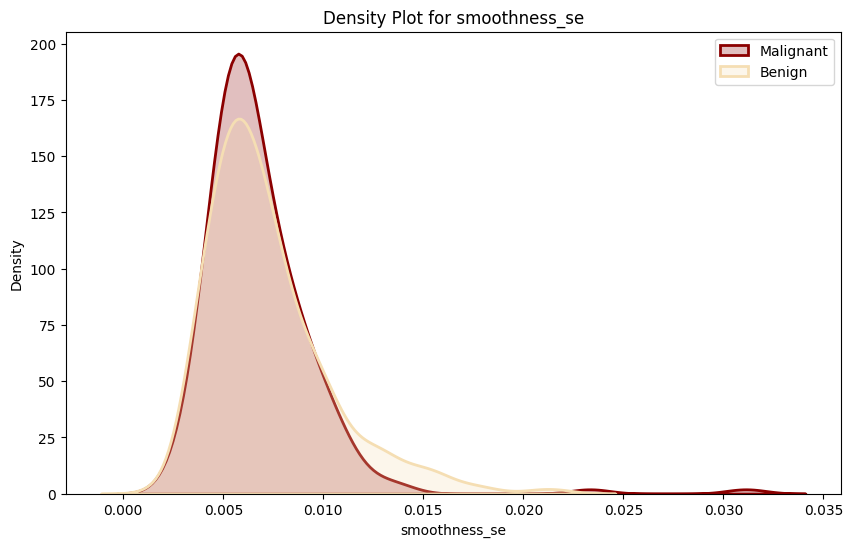

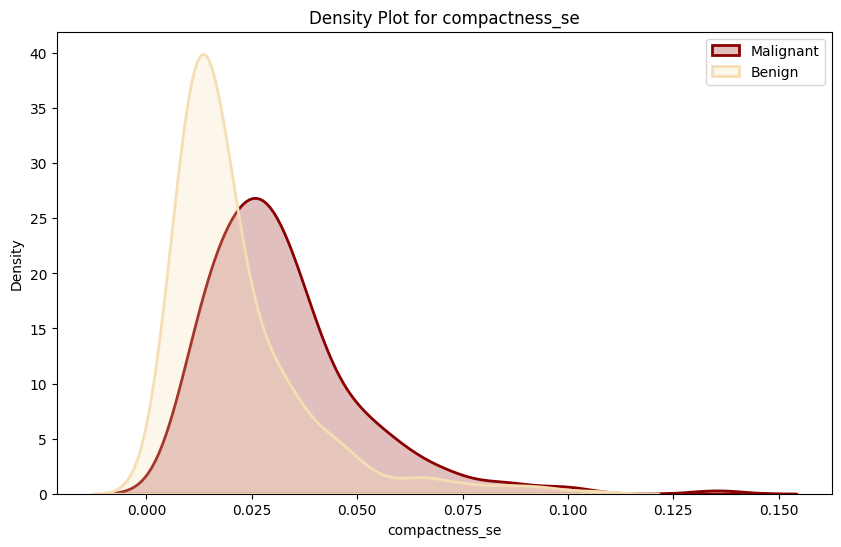

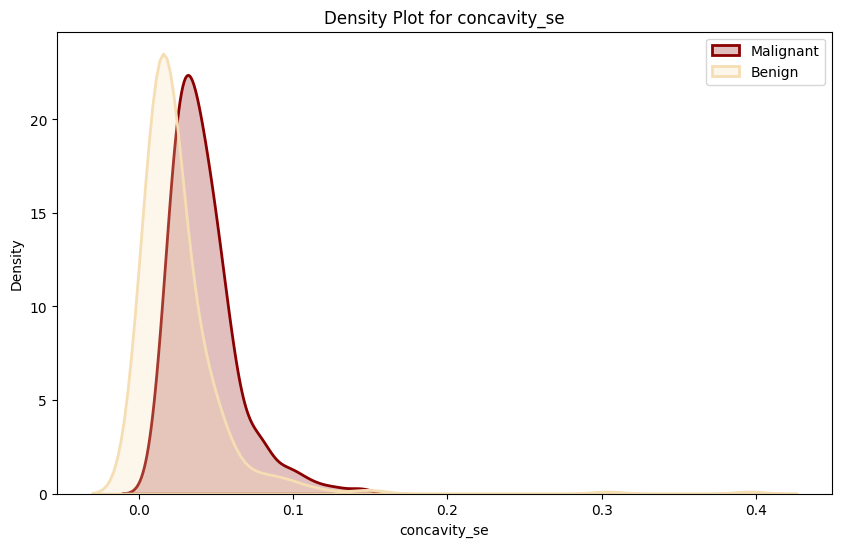

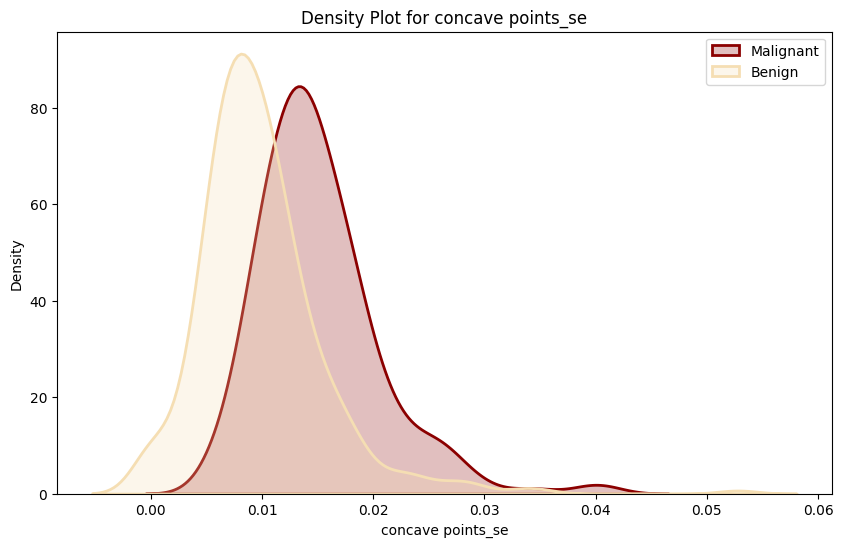

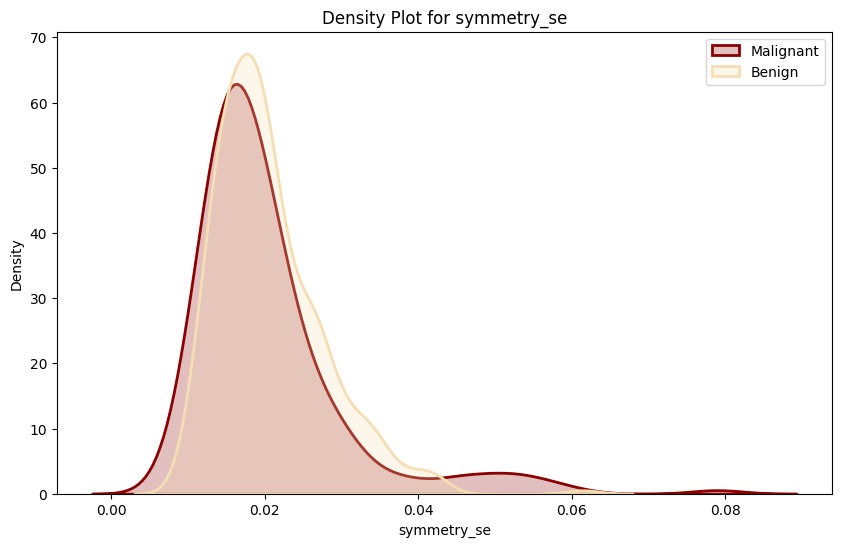

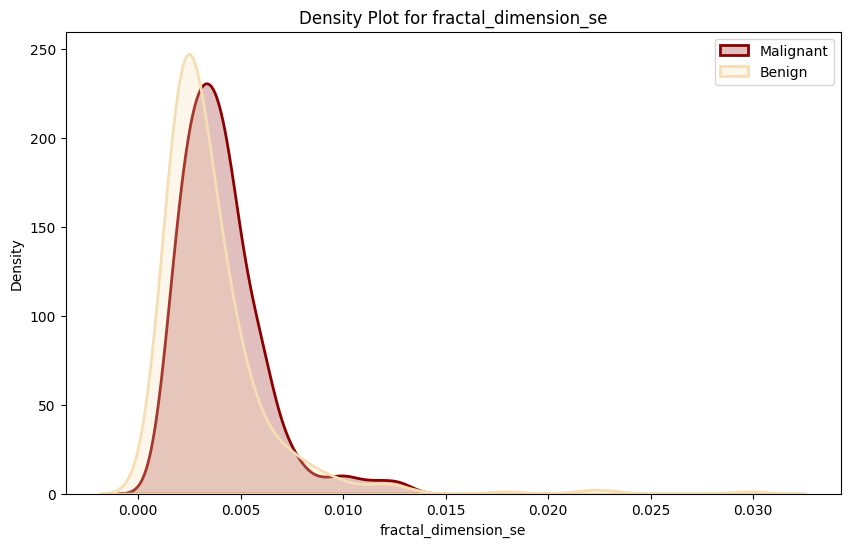

In [13]:
#Standard Error Features
distributionPlots('radius_se', .1)
distributionPlots('texture_se', .1)
distributionPlots('perimeter_se', .5)
distributionPlots('area_se', 5)
distributionPlots('smoothness_se', .5)
distributionPlots('compactness_se', .5)
distributionPlots('concavity_se', .5)
distributionPlots('concave points_se', .5)
distributionPlots('symmetry_se', .5)
distributionPlots('fractal_dimension_se', .5)

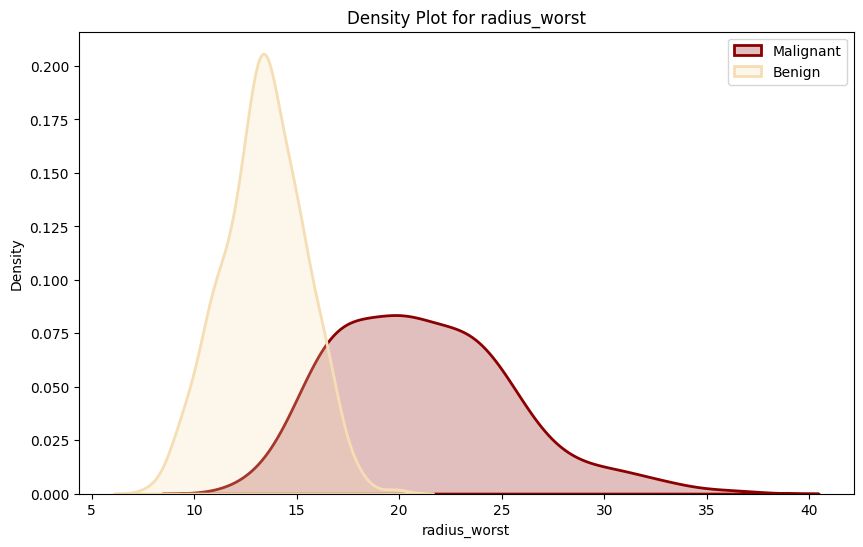

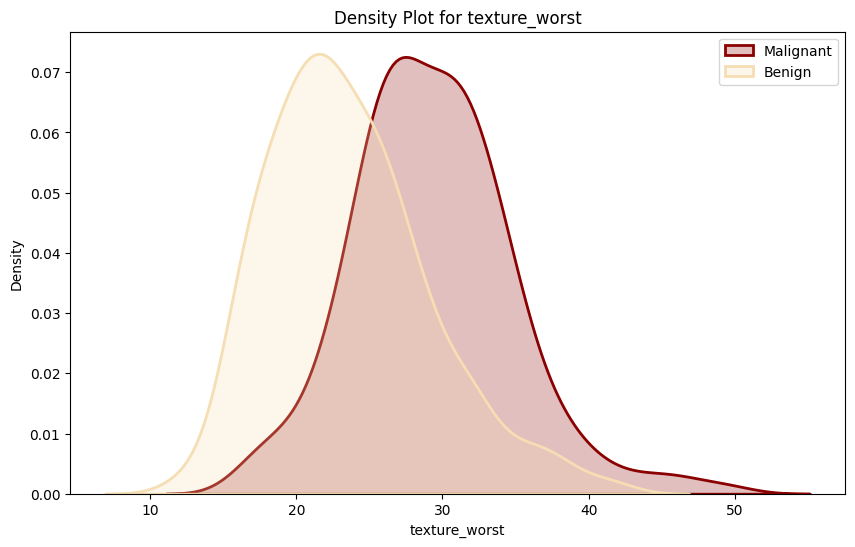

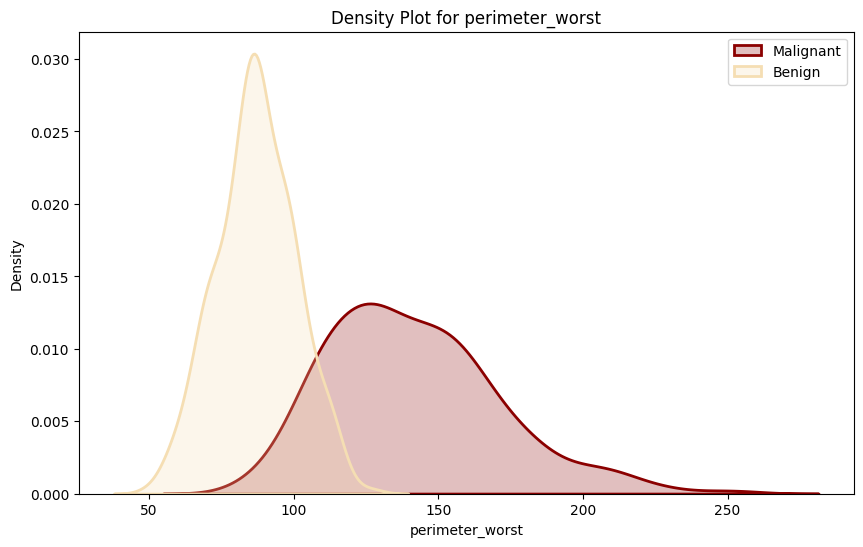

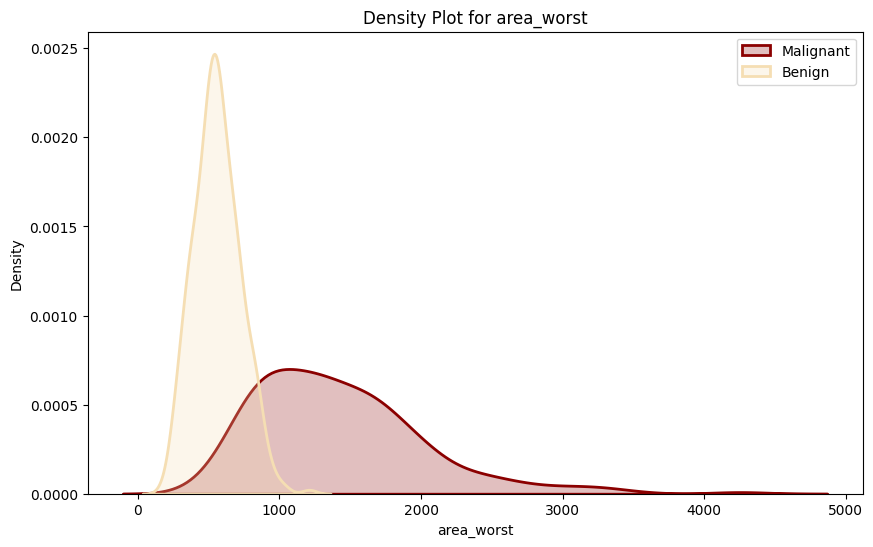

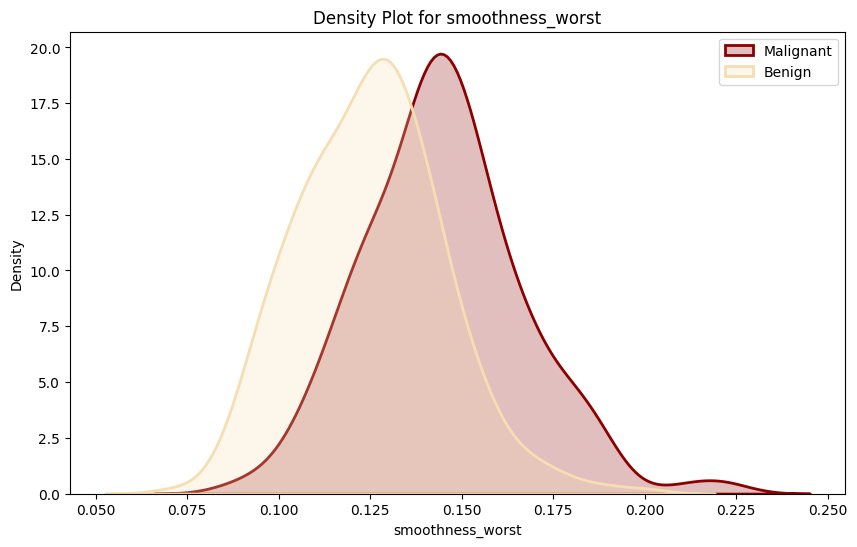

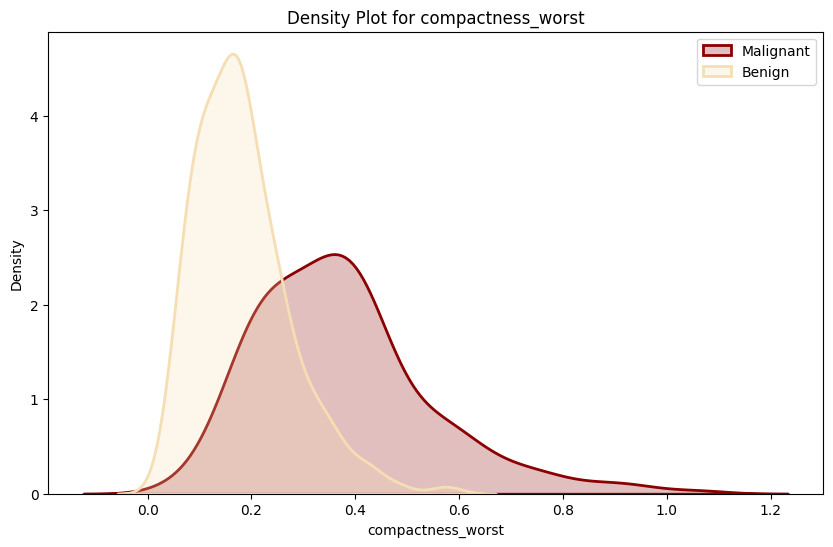

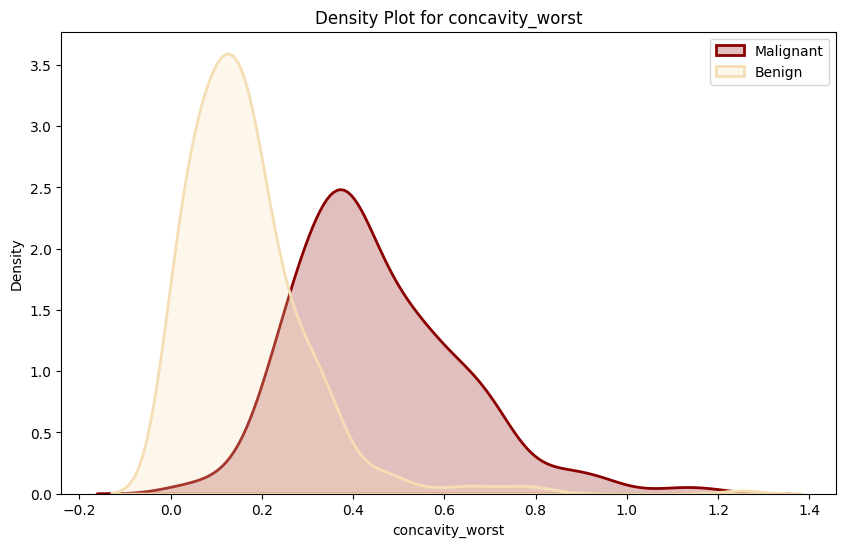

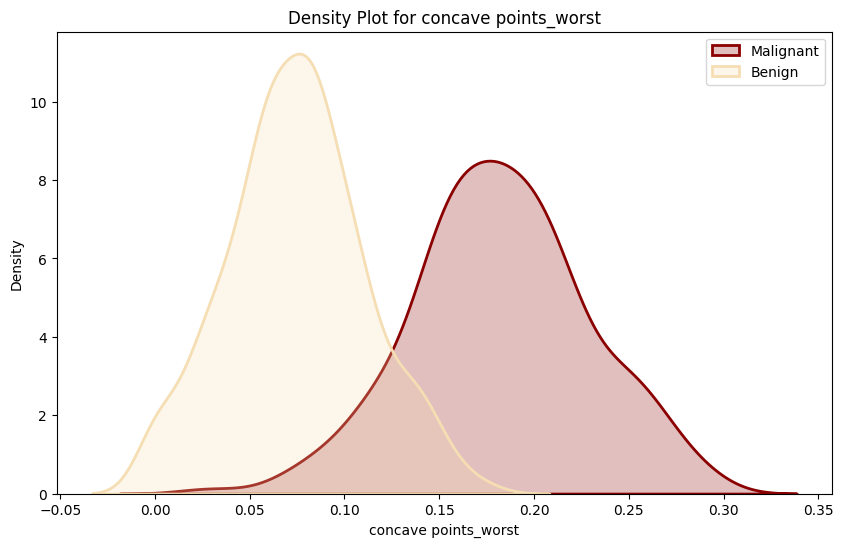

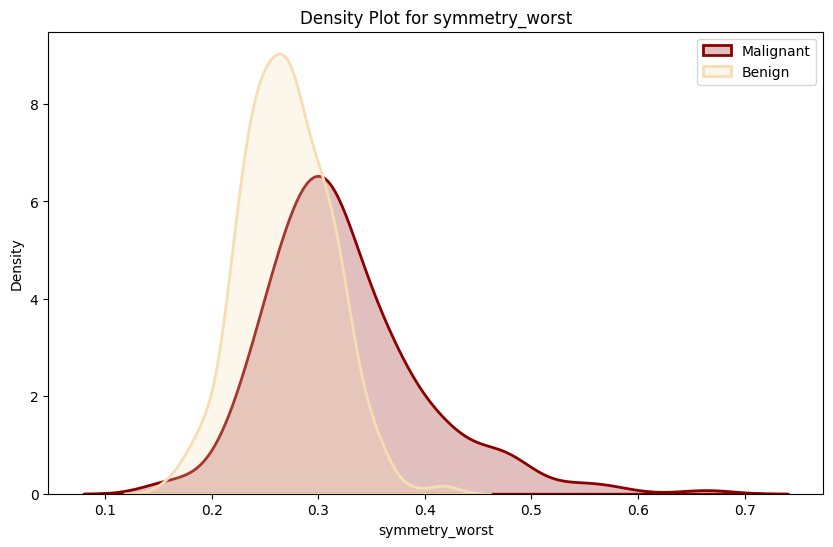

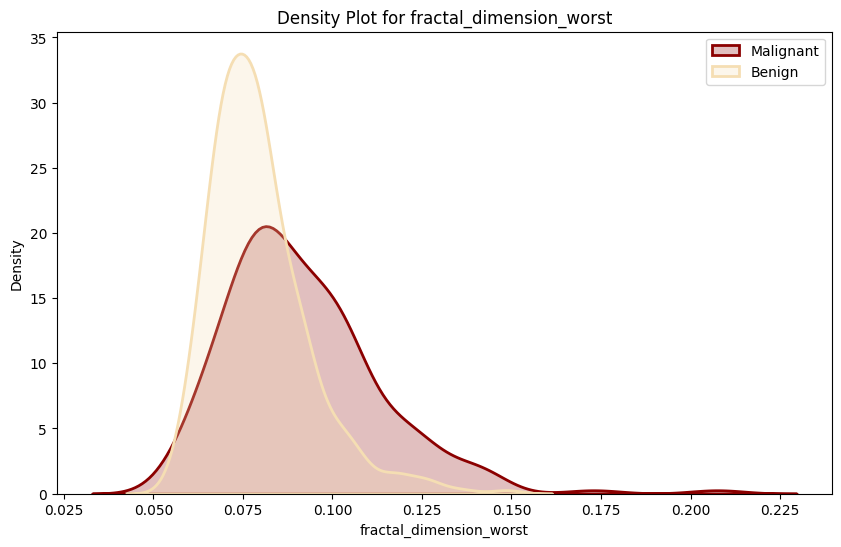

In [14]:
#Worst Features
distributionPlots('radius_worst', .5)
distributionPlots('texture_worst', .5)
distributionPlots('perimeter_worst', 5)
distributionPlots('area_worst', 10)
distributionPlots('smoothness_worst', .5)
distributionPlots('compactness_worst', .5)
distributionPlots('concavity_worst', .5)
distributionPlots('concave points_worst', .5)
distributionPlots('symmetry_worst', .5)
distributionPlots('fractal_dimension_worst', .5)

<Axes: >

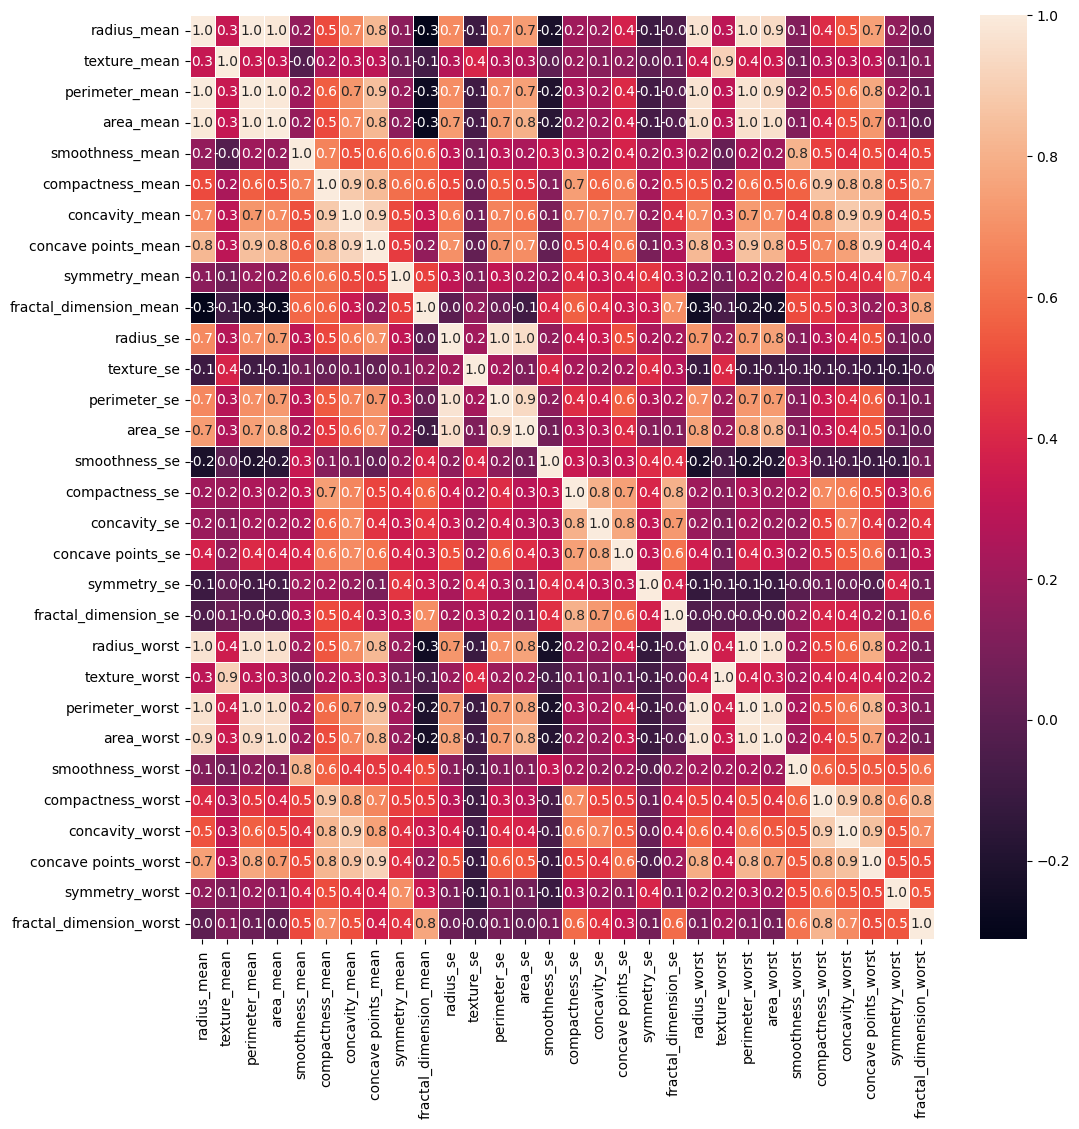

In [15]:
#Correlation Matrix
correlation = data.corr()
predictors = data.drop(['diagnosis'], axis = 1)

f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(predictors.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [16]:
#Scatter Plots
def scatterPlots(data, x1, y1, x2, y2, palette, edgecolor, title):
    diagnosis_labels = {0: 'Malignant', 1: 'Benign'}

    # Plot +
    fig = plt.figure(figsize=(14, 12))

    plt.subplot(221)
    scatter1 = sns.scatterplot(x=data[x1], y=data[y1], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
    scatter1.legend(labels=[diagnosis_labels[label] for label in sorted(data['diagnosis'].unique())])
    plt.title(f'{x1} vs {y1}')

    plt.subplot(222)
    scatter2 = sns.scatterplot(x=data[x2], y=data[y2], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
    scatter2.legend(labels=[diagnosis_labels[label] for label in sorted(data['diagnosis'].unique())])
    plt.title(f'{x2} vs {y2}')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    #plt.savefig(title.lower().replace(' ', '_') + '.png')
    plt.show()

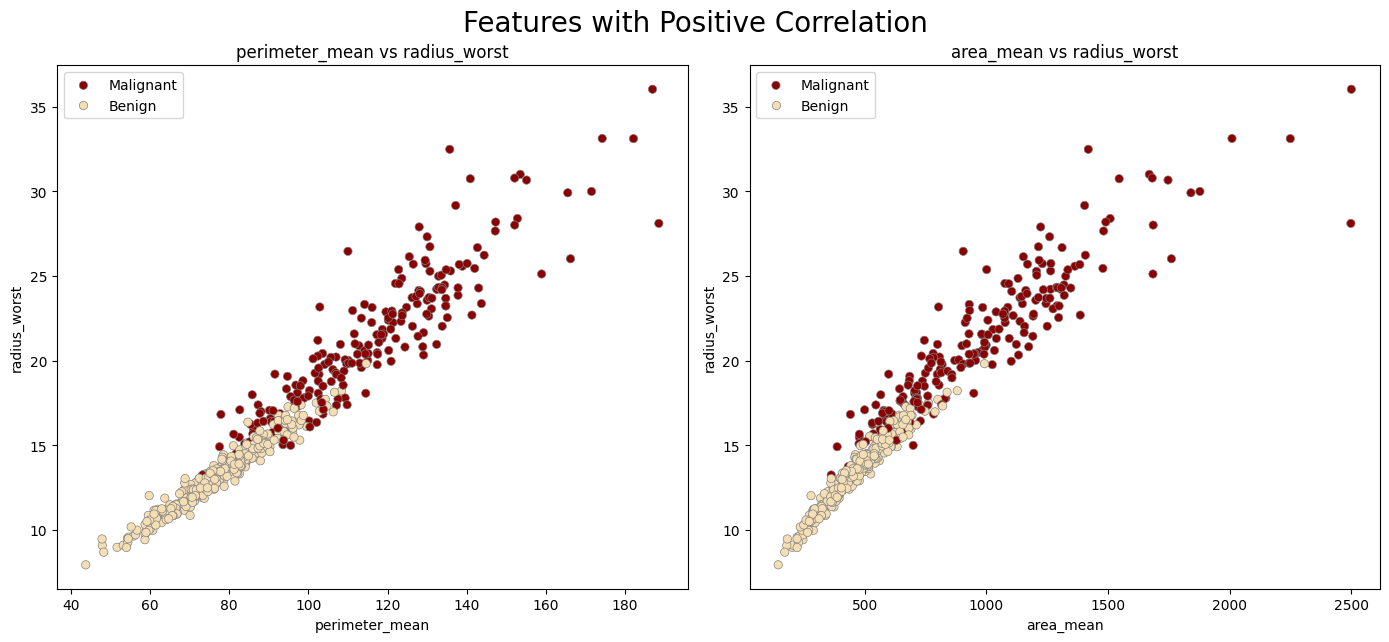

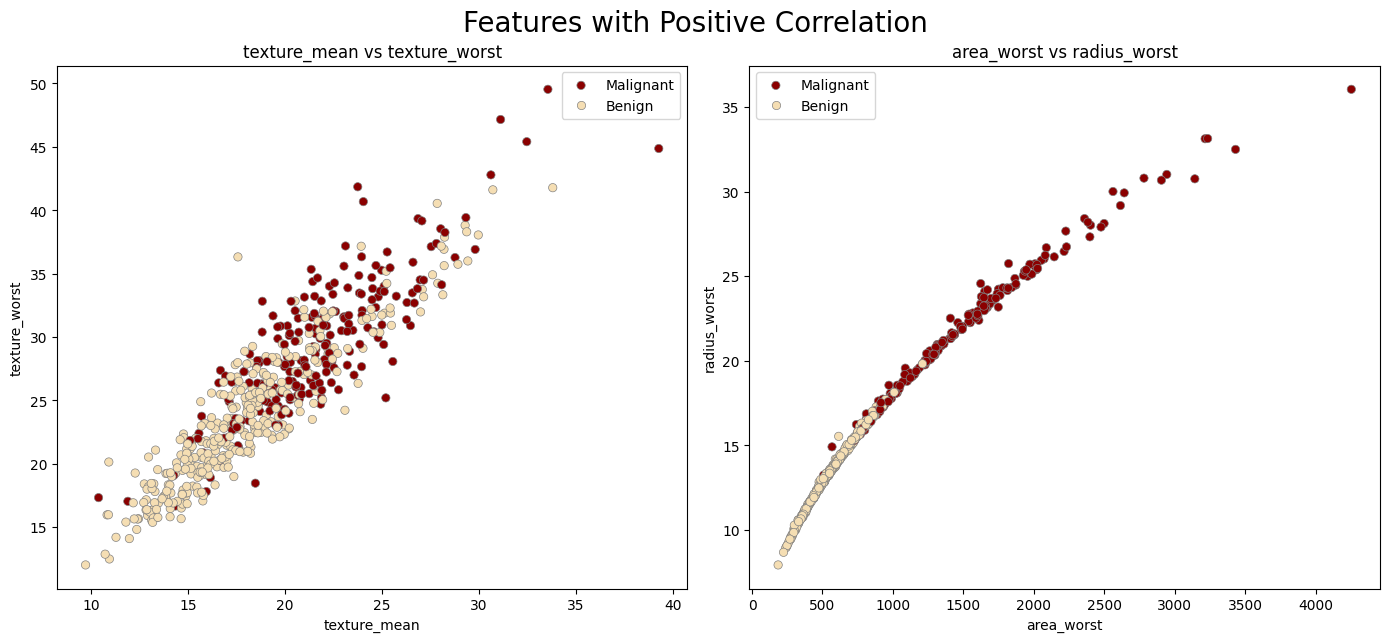

In [17]:
#Features with Positive Correlation
scatterPlots(data, 'perimeter_mean', 'radius_worst', 'area_mean', 'radius_worst', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Positive Correlation')
scatterPlots(data, 'texture_mean', 'texture_worst', 'area_worst', 'radius_worst', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Positive Correlation')

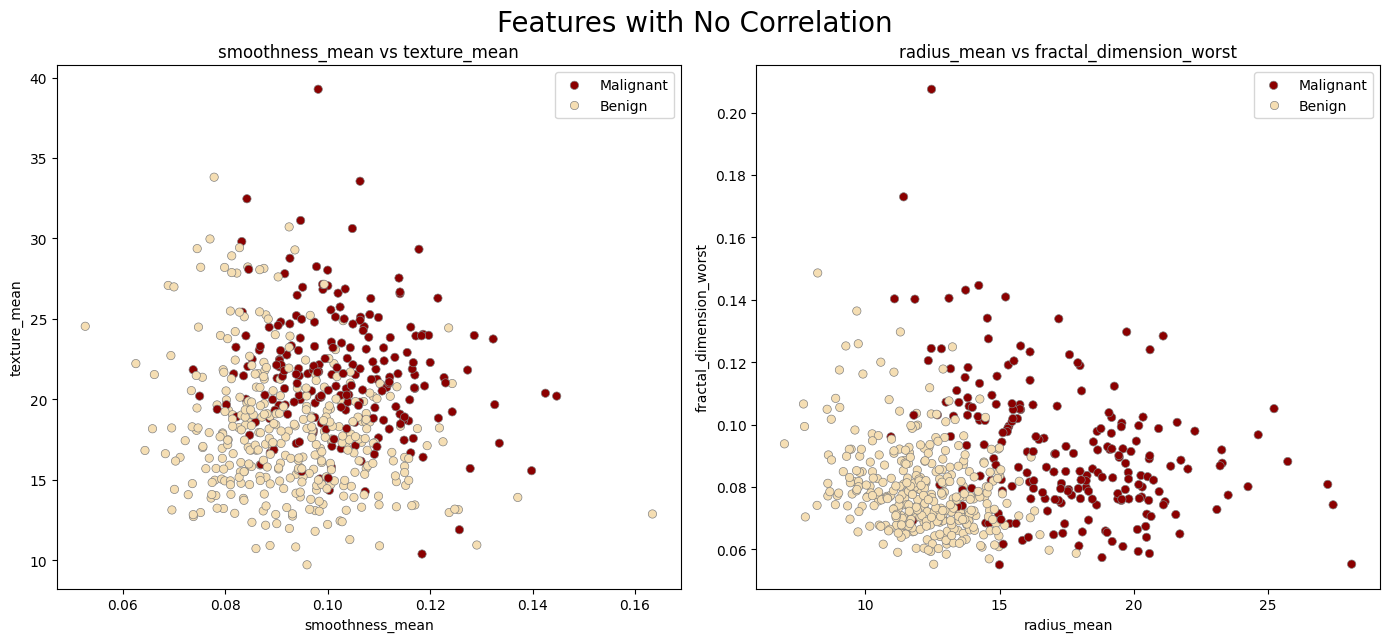

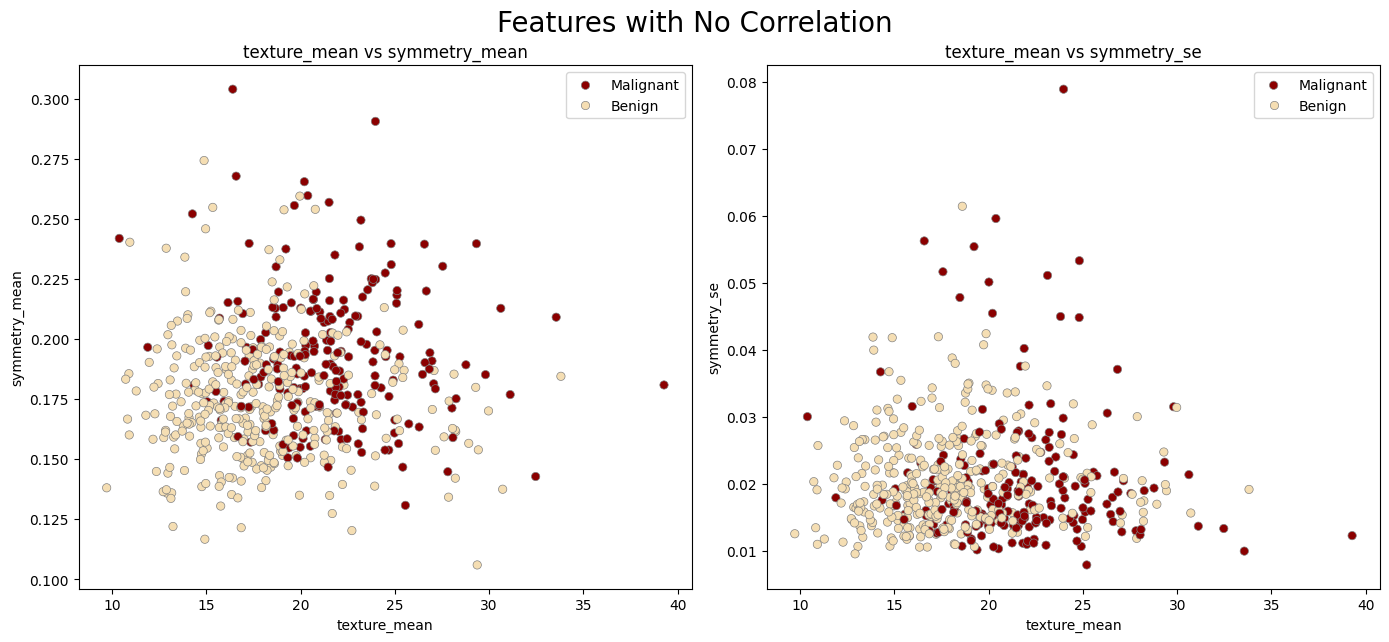

In [18]:
#Features with No Correlation
scatterPlots(data, 'smoothness_mean','texture_mean', 'radius_mean','fractal_dimension_worst', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with No Correlation')
scatterPlots(data, 'texture_mean','symmetry_mean', 'texture_mean','symmetry_se', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with No Correlation')

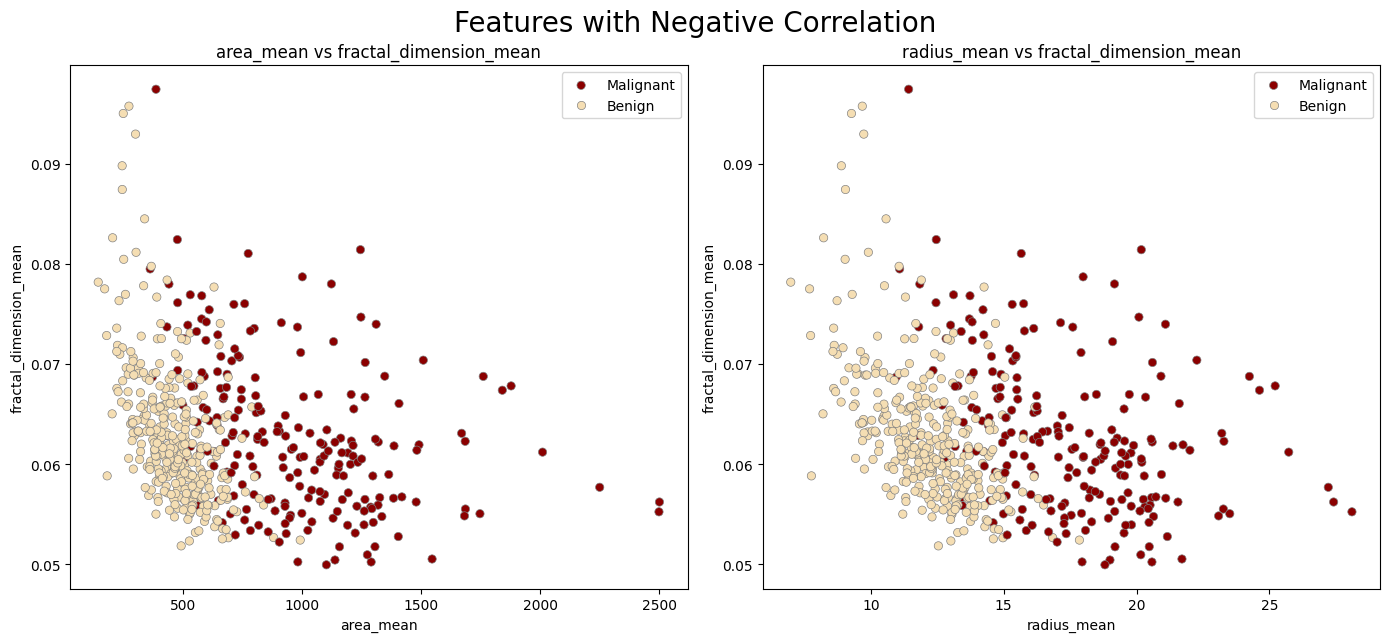

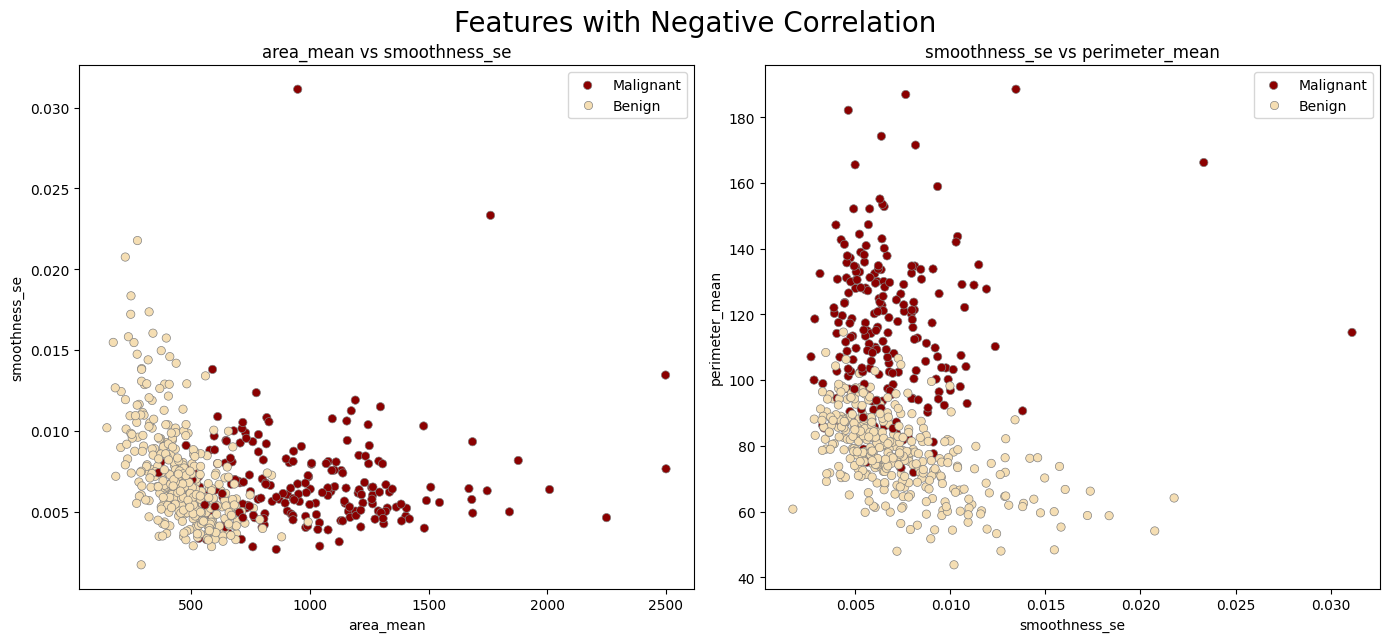

In [19]:
# Features with Neagtive Correlation
scatterPlots(data, 'area_mean','fractal_dimension_mean', 'radius_mean','fractal_dimension_mean', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Negative Correlation')
scatterPlots(data, 'area_mean','smoothness_se', 'smoothness_se','perimeter_mean', {0: 'wheat', 1: 'darkred'}, 'grey', 'Features with Negative Correlation')

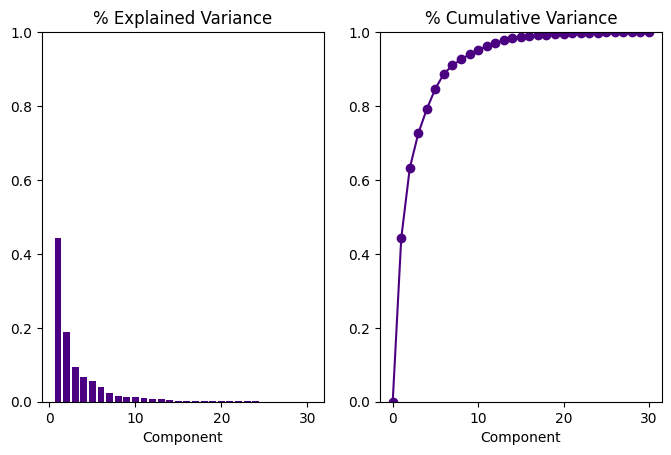

In [20]:
df = pd.read_csv(path)

df = df.drop(['Unnamed: 32', 'id'], axis=1)

df.diagnosis.replace(to_replace=dict(M=1, B=0), inplace=True)

M = df[df['diagnosis'] != 0]
B = df[df['diagnosis'] == 0]

y = np.array(df.diagnosis.tolist())
X = df.drop('diagnosis', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# standardize & PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# convert pc to df
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

# explained variance. using this to select the # best of components
def plot_variance(pca):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr, color='indigo')
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-", color='indigo')
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
    fig.set(figwidth=8, dpi=100)
    plt.show()

plot_variance(pca)

Top three features for PC1: Index(['concave points_mean', 'concavity_mean', 'concave points_worst'], dtype='object')
Top three features for PC2: Index(['fractal_dimension_mean', 'fractal_dimension_se',
       'fractal_dimension_worst'],
      dtype='object')


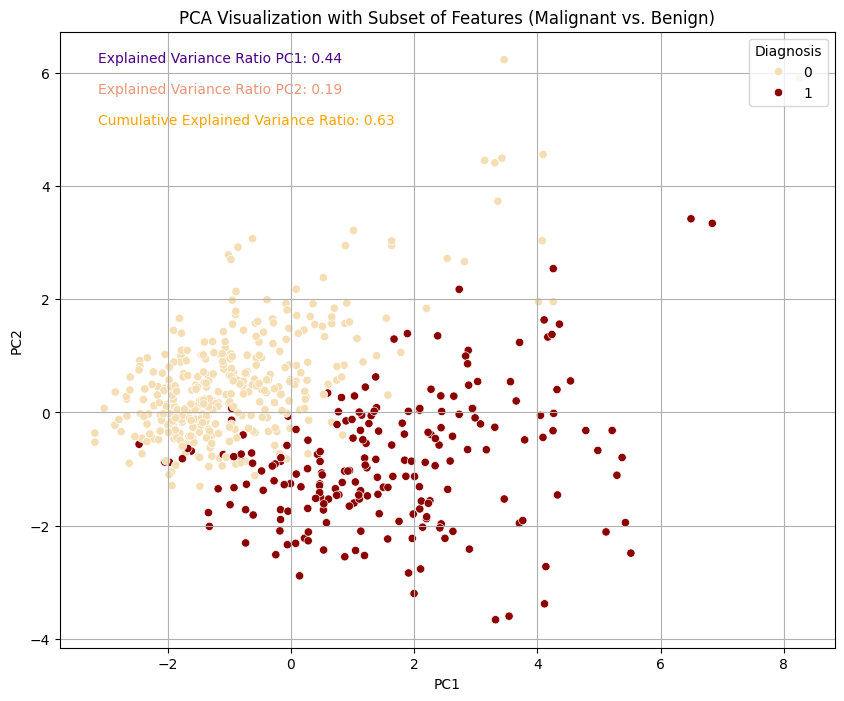

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

loadings = pca.components_
abs_loadings = np.abs(loadings)


# top three for each PC
top_three_indices_pc1 = np.argsort(abs_loadings[0])[::-1][:3]
top_three_indices_pc2 = np.argsort(abs_loadings[1])[::-1][:3]
top_three_features_pc1 = X.columns[top_three_indices_pc1]
top_three_features_pc2 = X.columns[top_three_indices_pc2]
print("Top three features for PC1:", top_three_features_pc1)
print("Top three features for PC2:", top_three_features_pc2)

X_subset = X[top_three_features_pc1.append(top_three_features_pc2)]

# Standardize the subset of features
scaler_subset = StandardScaler()
X_subset_scaled = scaler_subset.fit_transform(X_subset)

#pca using best # of components
pca_subset = PCA(n_components=2)
X_pca_subset = pca_subset.fit_transform(X_subset_scaled)

component_names_subset = [f"PC{i+1}" for i in range(X_pca_subset.shape[1])]
X_pca_subset = pd.DataFrame(X_pca_subset, columns=component_names_subset)

# plot PCA w/ k=2. each PC has features selected using the three highest features
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue=y, data=X_pca_subset, palette=['wheat', 'darkred'])
plt.title('PCA Visualization with Subset of Features (Malignant vs. Benign)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Diagnosis', loc='upper right')
plt.grid(True)

#explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.annotate(f'Explained Variance Ratio PC1: {explained_variance_ratio[0]:.2f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='indigo')
plt.annotate(f'Explained Variance Ratio PC2: {explained_variance_ratio[1]:.2f}', 
             xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10, color='darksalmon')
plt.annotate(f'Cumulative Explained Variance Ratio: {cumulative_variance_ratio[1]:.2f}', 
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='orange')

plt.show()


perimeter_worst            0.473387
area_worst                 0.463288
radius_worst               0.454272
concave points_mean        0.437704
concave points_worst       0.436119
perimeter_mean             0.402936
concavity_mean             0.375148
radius_mean                0.361199
area_mean                  0.359468
area_se                    0.337170
concavity_worst            0.315259
perimeter_se               0.274658
radius_se                  0.245417
compactness_worst          0.226367
compactness_mean           0.216178
concave points_se          0.128491
texture_worst              0.118904
concavity_se               0.109279
smoothness_worst           0.100109
texture_mean               0.094937
symmetry_worst             0.089993
smoothness_mean            0.077111
compactness_se             0.075095
symmetry_mean              0.069241
fractal_dimension_worst    0.061798
fractal_dimension_se       0.035662
smoothness_se              0.018691
symmetry_se                0

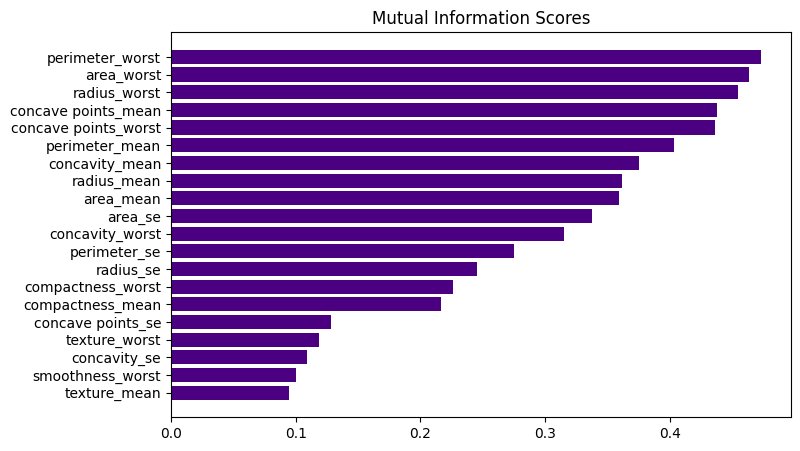

In [22]:

# calculate mutual info scores
def make_mi_scores(X, y):
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, color='darkred'):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

mi_scores = make_mi_scores(X, y)
print(mi_scores)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20), color='indigo')